In [45]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import warnings
import sklearn.preprocessing
from scipy.stats import zscore
from functions import *
#from termcolor import colored



warnings.filterwarnings('ignore') #supresses warnings for now
#warnings.filterwarnings(action='once') #shows warnings once

dataFilePathClinic = os.path.join(os.getcwd(),'Data')
dataFilePath = os.path.join(os.getcwd(),'Data/genomic_location_files')

colNames = ['chromA', 'startA', 'endA', 'chromB', 'startB', 'endB', 'id', 'dId']

kics_100kb = pd.read_csv(os.path.join(dataFilePath,'kics_te_100_sorted.bed'), sep = '\t', header = None, names = colNames)
kics_10kb = pd.read_csv(os.path.join(dataFilePath,'kics_te_10_sorted.bed'), sep = '\t', header = None, names = colNames)
kics_1kb = pd.read_csv(os.path.join(dataFilePath,'kics_te_1_sorted.bed'), sep = '\t', header = None, names = colNames)

lfs_100kb = pd.read_csv(os.path.join(dataFilePath,'lfs_te_100_sorted.bed'), sep = '\t', header = None, names = colNames)
lfs_10kb = pd.read_csv(os.path.join(dataFilePath,'lfs_te_10_sorted.bed'), sep = '\t', header = None, names = colNames)
lfs_1kb = pd.read_csv(os.path.join(dataFilePath,'lfs_te_1_sorted.bed'), sep = '\t', header = None, names = colNames)


lfsClinicdf = pd.read_csv(os.path.join(dataFilePathClinic,'lfs_clinical_main.tsv'), sep = '\t', header = 0)
kicsClinicdf = pd.read_csv(os.path.join(dataFilePathClinic,'kics_clinical_edited.csv'), encoding='latin-1')


In [2]:
"""
Group and make into matrix
"""
def chromFix(row):
    chrom = row['chromA']
    chrom = chrom.replace('chr', '')
    
    #should just be the number or x / y now
    try:
        return int(chrom)
    except:
        return chrom


def createMatrix (df: pd.DataFrame) -> pd.DataFrame:
    df.drop(['endA','chromB','startB','endB','dId'],axis=1,inplace=True)
    df['chromA'] = df.apply(lambda row: chromFix(row), axis=1)    
    df['id'] = df['id'].str.replace(".realigned-recalibrated","")
    
    matrix = df.groupby(['chromA','startA','id'],sort=False).value_counts().to_frame()
    matrix = matrix.rename(columns={0: 'freq'})
    matrix = matrix.unstack(fill_value = 0)
    matrix.columns = matrix.columns.droplevel()
    
    return matrix

In [3]:
"""
Z-score normalized tables
"""
def zScoreNorm(df:pd.DataFrame)->pd.DataFrame:
    df = df.transpose()
    for i in df.columns:
        df[i] = zscore(df[i])
    
    df = df.transpose()
    
    return df

In [4]:
"""
Remove samples that only have 1 variation
"""
def cleanMatrix(df:pd.DataFrame) -> pd.DataFrame:
    colRemove = []

    for i in df.columns:
        listUnique = np.unique(df[i].values)
        listUnique = listUnique[listUnique != 0]

        #if the list only has 1 non zero element check if there is only 1 occurrance
        if len(listUnique)<=1:
            sumCol = df[i]
            minimumSum = sum(listUnique)
            sumCol = sumCol.sum()

            if sumCol == minimumSum:
                colRemove.append(i)             

    df = df.drop(colRemove,axis=1)
    return df

In [5]:
"""
Clustering by group
seaborn cluster map > different from heat map
quantile transformation > 
center z score? read it > 
"""

'\nClustering by group\nseaborn cluster map > different from heat map\nquantile transformation > \ncenter z score? read it > \n'

In [6]:
# """
# what the 
# small man confused what is quantile_transform
# """

# matrixQuartile = sklearn.preprocessing.quantile_transform(matrixA, n_quantiles=4)
# print(np.sum(matrixQuartile))

# CLEANING

In [7]:
"""
Kics clinic df cleaning
"""
listValSearch = ['63', '83', '156', '171', '219', '120', '141', '232']

kicsClinicdf['KiCS ID'] = kicsClinicdf['KiCS ID'].astype(str)
kicsClinicdf['KiCS ID'] = kicsClinicdf['KiCS ID'].str.replace(" ", "")

for i in listValSearch:
    kicsClinicdf.drop(kicsClinicdf[kicsClinicdf['KiCS ID']==i].index, inplace = True)

kicsClinicdf.drop(kicsClinicdf.loc[kicsClinicdf['tissue_type']=='?'].index, inplace=True)
kicsClinicdf.drop(kicsClinicdf.loc[pd.isna(kicsClinicdf['lfs_cancer_type_diagnosis'])].index, inplace=True)

In [8]:
UberbigKDf = kIdAbbv(kicsClinicdf, kics_100kb, 'CCP germline', 'id')
UberbigKDf=UberbigKDf.rename(columns={'lfs_cancer_type_diagnosis': 'cancer_diagnosis', 'diagnosis_age (days)':'ageofonset'})
UberbigKDf['ageofonset'] = UberbigKDf['ageofonset'].astype('float')
UberbigKDf['ageofonset'] = UberbigKDf.apply(lambda row:ageOfOnsetKics(row) ,axis=1)

print(UberbigKDf.columns)
#prints out how many we had before the id matching and how many we have left after the id matching

80
Index(['chromA', 'startA', 'endA', 'chromB', 'startB', 'endB', 'id', 'dId',
       'abbv_id', 'KiCS ID', 'ICDO-diagnosis', 'tissue_type',
       'cancer_diagnosis', 'Revised diagnosis based on NGS',
       'Previous cancers', 'Include/Exclude in paper', 'EP1/EP2',
       'Germline only', 'CCP germline', 'Germline Sample from',
       'Germline sample type', 'CCP germline.1', 'WGS DNA germline',
       'WGS germline', 'pathology_id', 'Sample type', 'CCP tumor', 'CCP PPID',
       'CCP', 'WGS tumor ID', 'WGS Tumor', 'RNA ID', 'RNA',
       'single_somatic_specimen', 'surgical date for the sample',
       'disease_state', 'sample_type', 'post_treatment', 'sample site',
       'tumour_class', 'Sex', 'ageofonset',
       'enrollment_age (days or deceased)', 'somatic_finding_a',
       'somatic_finding_b', 'somatic_finding_c', 'somatic_finding_d',
       'germline_finding_a', 'germline_finding_b', 'germline_finding_c',
       'germline_finding_d', 'actionable_findings_order', 'abbreviatio

In [9]:
"""
Lfs clinic df cleaning
"""
lfsClinicdf['sample'] = lfsClinicdf['sample'].astype(str)
lfsClinicdf['sample'] = lfsClinicdf['sample'].str.replace(" ", "")

for i in listValSearch:
    lfsClinicdf.drop(lfsClinicdf[lfsClinicdf['sample']==i].index, inplace = True)
        
lfsClinicdf.drop(lfsClinicdf.loc[lfsClinicdf['tissue_type']=='?'].index, inplace=True)
lfsClinicdf.drop(lfsClinicdf.loc[pd.isna(lfsClinicdf['cancer_diagnosis'])].index, inplace=True)

In [10]:
lfsClinicdf['sample'] = lfsClinicdf['sample'].astype(str)

In [11]:
"""
Can directly map the two
Apply on Filtered Prelim Graphs
"""
UberbigLDf = pd.merge(lfs_100kb,
                 lfsClinicdf,
                 left_on = 'id',
                 right_on = 'sample',
                 how='inner')
UberbigLDf['ageofonset'] = UberbigLDf.apply(lambda row:ageOfOnsetLfs(row) ,axis=1)

# Heat map

In [12]:
"""
Todo:
- cleaning + mapping of kics >done
- mapping the lfs >done
- generate all heat map graphs >working on it
- generate Umap
- generate PCA
"""

'\nTodo:\n- cleaning + mapping of kics >done\n- mapping the lfs >done\n- generate all heat map graphs >working on it\n- generate Umap\n- generate PCA\n'

In [13]:
#Plots colours for legened -> copied from matplotlib: https://matplotlib.org/stable/gallery/color/named_colors.html
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


def plot_colortable(colors:dict, emptycols=0):

    cell_width = 212
    cell_height = 22
    swatch_width = 48
    margin = 12

    names = list(colors)
    n = len(names)
    ncols = 4 - emptycols
    nrows = n // ncols + int(n % ncols > 0)

    width = cell_width * 4 + 2 * margin
    height = cell_height * nrows + 2 * margin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, margin/height,
                        (width-margin)/width, (height-margin)/height)
    ax.set_xlim(0, cell_width * 4)
    ax.set_ylim(cell_height * (nrows-0.5), -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()

    for i, name in enumerate(names):
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        text_pos_x = cell_width * col + swatch_width + 7

        ax.text(text_pos_x, y, name, fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')
    
        ax.add_patch(
            Rectangle(xy=(swatch_start_x, y-9), width=swatch_width,
                      height=18, facecolor=colors[name], edgecolor='0.7')
        )

    return fig

In [47]:
def colorDict(df, colName, listId):
    colors=['#BC8F8F','#4169E1','#008000','#FF69B4','#4B0082',
         '#9370DB','#6B8E23','#800080','#FFDAB9','#EEE8AA',
        '#0000FF','#00008B','#FF00FF','#F08080','#C0C0C0',
        '#4682B4','#3CB371','#DC143C','#696969','#DCDCDC','FFFFE0']
    
    col = colors[0:len(df[colName].unique())]
    dictionaryFeat = dict(zip(df[colName].unique(), col))
    unique = df[colName].unique()
    dictionaryId = dict()
    
    for i in listId:
        if not df.loc[df['id']==i,colName].empty:
            dictionaryId[i] = df.loc[df['id']==i, colName].iloc[0]
    
    columns = list(dictionaryId)
    columns_colours = pd.Series(columns).map(lambda x: dictionaryFeat[dictionaryId[x]])
    columns_colours.index = columns
    plot_colortable(dictionaryFeat)
    plt.show()
    
    return columns, columns_colours
    
    
def clusterMap(df:pd.DataFrame, uberDf, featNames):
    matrix1 = createMatrix(df)
    matrix = cleanMatrix(matrix1)

    colourList = []
    
    for i in featNames:
        columns,columns_colours = colorDict(uberDf, i, matrix.columns)
        colourList.append(columns_colours)
        matrix = matrix.drop(list(set(matrix.columns)-set(columns)),axis=1)

    sns.clustermap(matrix, row_cluster = False, col_colors=colourList)

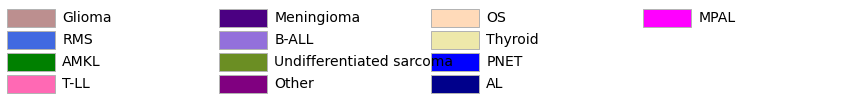

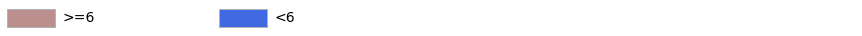

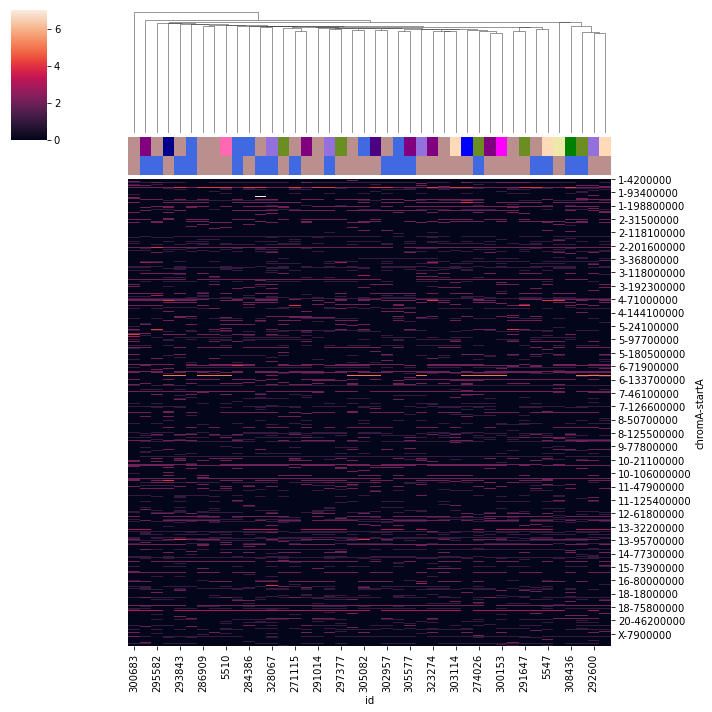

In [40]:
clusterMap(kics_100kb, UberbigKDf, ['cancer_diagnosis','ageofonset'])

In [41]:
#print(UberbigLDf['Hospital'])

Index(['chromA', 'startA', 'endA', 'chromB', 'startB', 'endB', 'id', 'dId',
       'sample', 'meth_id',
       ...
       'SV_nonCPG', 'SV_CPG', 'CancerOnly_Candidate_P_nonCPG',
       'Protective_Candidates', 'MSK_Actionable_1', 'MSK_Actionable_2',
       'MSK_Actionable_3', 'MSK_Actionable_4', 'MSK_Actionable_R1',
       'MSK_Actionable_R2'],
      dtype='object', length=108)


['ACC' 'CPC' 'RMS' 'LMS' 'CSA' 'Breast' 'OS' 'Unaffected' 'AA' 'MFH'
 'High Grade Sarcoma' 'US' 'MFS' 'Colon' 'Glioma' 'ALL']


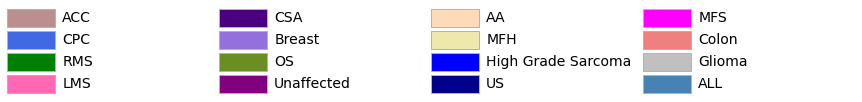

['<6' '>=6' None]


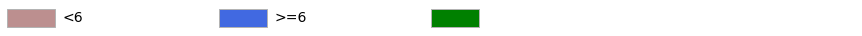

['SickKids' 'CHLA' 'SickKids/LHSC' 'COG' 'Umichigan' 'MSH' 'McMaster'
 'Huntsman UT' 'LHSC' 'JohnsHopk' 'SickKids/MSH' 'CapeBreton'
 'Pinto et al.' 'CHOP' 'CHEO' 'CHLA/MemSloan' 'RCH-Melbourne' 'Sanger']


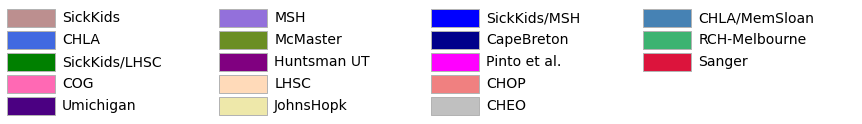

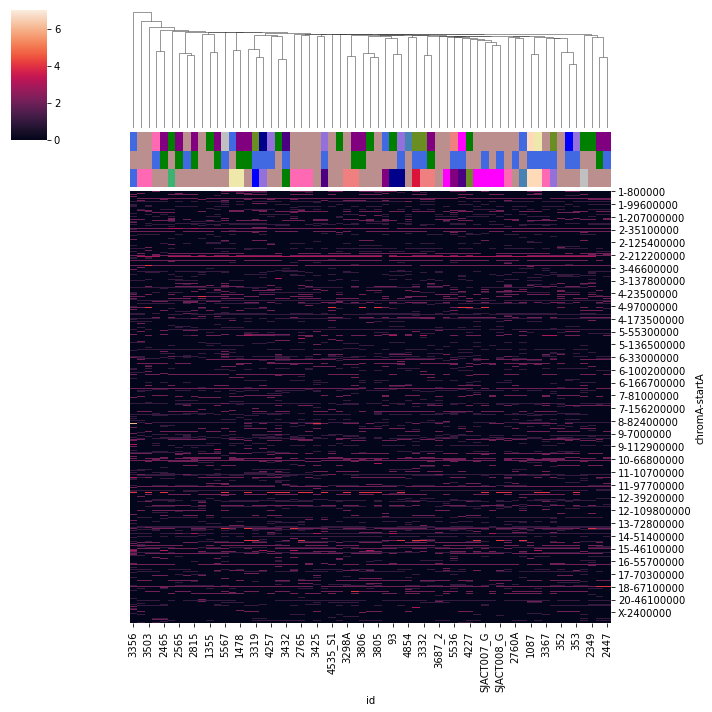

In [46]:
clusterMap(lfs_100kb, UberbigLDf, ['cancer_diagnosis','ageofonset','Hospital'])

#no name means unaffected!!

In [ ]:
#matrixA = createMatrix(kics_100kb)

In [ ]:
#matrixA = cleanMatrix(matrixA)

In [ ]:
#pd.set_option('display.max_rows',None)
#print(matrixA.head(9000))

In [ ]:
"""
Colours for cancer type
"""
# colors=['#BC8F8F','#4169E1','#008000','#FF69B4','#4B0082',
#          '#9370DB','#6B8E23','#800080','#FFDAB9','#EEE8AA',
#         '#0000FF','#00008B','#FF00FF','#F08080','#C0C0C0',
#         '#4682B4','#3CB371','#DC143C','#696969','#DCDCDC','FFFFE0']


#columns = matrixA.columns
#dictId = dict()

#colours = colors[0:len(UberbigKDf['cancer_diagnosis'].unique())]

#dictCancer = dict(zip(UberbigKDf['cancer_diagnosis'].unique(),colours))
#print(dictCancer)

#cancerUnique = UberbigKDf['cancer_diagnosis'].unique()
#print(cancerUnique)

#for i in columns:
#    if not UberbigKDf.loc[UberbigKDf['id']==i,'cancer_diagnosis'].empty:
#        dictId[i]=UberbigKDf.loc[UberbigKDf['id']==i,'cancer_diagnosis'].iloc[0]
        
#columns = list(dictId)

#sns.clustermap(matrixA, row_colors=network_colours)

In [ ]:
"""
One for institution>lfs only tho
Another for age of onset?
"""

# columns2 = matrixA.columns
# dictId2 = dict()

# colorsAOO = colors[0:len(UberbigKDf['ageofonset'].unique())]

# dictAgeOfOnset = dict(zip(UberbigKDf['ageofonset'].unique(),colorsAOO))
# print(dictAgeOfOnset)

# AOOunique = UberbigKDf['ageofonset'].unique()
# print(AOOunique)

# for i in columns2:
#     if not UberbigKDf.loc[UberbigKDf['id']==i,'ageofonset'].empty:
#         dictId2[i]=UberbigKDf.loc[UberbigKDf['id']==i,'ageofonset'].iloc[0]

# #print(dictId) 
# columns2 = list(dictId2)

In [ ]:
columns_colours = pd.Series(columns).map(lambda x: dictCancer[dictId[x]])

columns_colours.index = columns

columns_colours2 = pd.Series(columns2).map(lambda x: dictAgeOfOnset[dictAgeofOnset[x]])
columns_colours2.index = columns2

#remove columns in matrix A that don't exist in the dictionary!!!!!!
matrixA = matrixA.drop(list(set(matrixA.columns)-set(columns)-set(columns2)),axis=1)


In [ ]:
#plot
plot_colortable(dictCancer)
plt.show()

sns.clustermap(matrixA,row_cluster = False,col_colors=[columns_colours, columns_colours2])

In [ ]:
"""
Plot KICS
"""



In [ ]:
"""
Create Matrix for All 6
"""

# listDf = [kics_100kb, kics_10kb, kics_1kb, lfs_100kb, lfs_10kb, lfs_1kb]
listDf = [kics_100kb]
matrixA = []

count=1
for i in listDf:
    print(str(count)+"----!!!!!!!!!!!!!!!")
    matrixA = createMatrix(i)
#     matrixB = matrixA.copy()
    
#     #plt.subplots(figsize=(50,360))
#     print("HEAT MAP A")
#     ax=sns.heatmap(matrixA)
#     plt.show()
# #add annotation
#     print("CLUSTER MAP A")
#     aax = sns.clustermap(matrixA, row_cluster = False,)
#     plt.show()

    matrixA = cleanMatrix(matrixA)
        
    print("HEAT MAP CLEANED")
    bx = sns.heatmap(matrixA)
    plt.show()

    print("HEAT MAP Z-SCORE")
    matrixA = zScoreNorm(matrixA)
    bxz = sns.heatmap(matrixA)
    plt.show()
    
    count = count+1
    

In [ ]:
"""
UMAP
"""
from umap import UMAP

plt.figure(figsize=(20,15))
model = UMAP(n_neighbors = 15, min_dist = 0.25, n_components = 2, verbose = True)
umap = model.fit_transform(kics_100kb)
plt.scatter(umap[:, 0], umap[:, 1], c = y_train.astype(int), cmap = 'tab10', s = 50)
plt.title('UMAP', fontsize = 20)
plt.xlabel("UMAP1", fontsize = 20)
plt.ylabel("UMAP2", fontsize = 20)
plt.show()
